In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import uproot
import glob
import yaml
import awkward as ak

plt.style.use('physics.mplstyle')

In [2]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = ak.to_numpy(f["limit"].arrays("limit")["limit"])
    quant = ak.to_numpy(f["limit"].arrays("quantileExpected")["quantileExpected"])
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])
    
def mass_points(kind="Scalar"):
    mass_points = {}
    for p in glob.glob("./fitroom/higgsCombineDMSimp_*{}*".format(kind)):
        mass_points[p] = [int(s) for s in re.findall(r'\d+',p)[:-1]]
    return mass_points

def get_cross_section(file):
    name = os.path.basename(file)
    with open("./config/xsection-DM.yaml", 'r') as stream:
        xsecs = yaml.safe_load(stream)
    name = name.replace("higgsCombine","")
    name = name.replace(".AsymptoticLimits.mH125.root","")
    xsec = xsecs[name]
    return xsec.get("xsec") * xsec.get("br") * xsec.get("kr")

In [3]:
 mass_points(kind="Scalar")

{'./fitroom/higgsCombineDMSimp_MonoZLL_Scalar_1000_mxd-1.AsymptoticLimits.mH125.root': [1000,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_100_mxd-1.AsymptoticLimits.mH125.root': [100,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_10_mxd-1.AsymptoticLimits.mH125.root': [10,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_150_mxd-1.AsymptoticLimits.mH125.root': [150,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_200_mxd-1.AsymptoticLimits.mH125.root': [200,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_250_mxd-1.AsymptoticLimits.mH125.root': [250,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_300_mxd-1.AsymptoticLimits.mH125.root': [300,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_350_mxd-1.AsymptoticLimits.mH125.root': [350,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_400_mxd-1.AsymptoticLimits.mH125.root': [400,
  1],
 './fitroom/higgsCombineDMSimp_MonoZLL_Scalar_450_mxd-1.AsymptoticLimits.mH125.root': [450,
  1],
 './fitroom/higgsCom

In [4]:
get_cross_section("./fitroom/higgsCombineDMSimp_MonoZLL_Scalar_10_mxd-1.AsymptoticLimits.mH125.root")

0.001782357069809

In [5]:
def plot_Scalar(unblind=True, preliminary=False):
    limit_MY = []
    limit_mx = []
    limit_lm = []
    xsec = []
    mZ = 91.1876
    
    for fn, mp in mass_points("Scalar").items():
        limit = get_limits(fn)
        if limit.shape == (2, 6):
            xsec.append(get_cross_section(fn))
            limit = np.array(limit).astype(float)
            limit_lm.append(limit)
            limit_MY.append(mp[0])
            limit_mx.append(mp[1])
        else:
            print("-> ", fn)
    
    xsec = np.array(xsec)
    data = pd.DataFrame(
        {
            "obs" : 0.02*np.array(limit_lm)[:,1,5]/xsec,
            "exp" : 0.02*np.array(limit_lm)[:,1,2]/xsec,
            "m1s" : 0.02*np.array(limit_lm)[:,1,1]/xsec,
            "p1s" : 0.02*np.array(limit_lm)[:,1,3]/xsec,
            "m2s" : 0.02*np.array(limit_lm)[:,1,0]/xsec,
            "p2s" : 0.02*np.array(limit_lm)[:,1,4]/xsec,
            "MY"  : np.array(limit_MY)
        }
    )
    data = data.sort_values(by=['MY'])
    plt.figure(figsize=(6.2,6))
    ax = plt.gca()
    plt.fill_between(data.MY, data.m1s, data.p1s,
                     color="#00CC00", lw=0, label="68% expected")
    plt.fill_between(data.MY, data.m2s, data.p2s,
                     color="#FFCC01", lw=0, label="95% expected")
    plt.fill_between(data.MY, data.m1s, data.p1s,
                     color="#00CC00", lw=0)
    plt.plot(data.MY, data.exp, marker='.', ls="--", ms=0, color="blue", label="Median expected")
    plt.plot(data.MY, data.obs, marker='.', ls="-", ms=0, color='black', label="Observed")
    plt.axhline(1, ls="--", color="red")
    plt.xlabel(r"$m_{\rm med}$ [GeV]", x=1, ha='right')
    plt.ylabel(r"$95\%$ CL limit on $\sigma_{obs}/\sigma_{theo}$", y=1, ha='right')
    plt.ylim([0.1, 1e4])
#     cms = plt.text(
#         0., 1., r"CMS $\it{Preliminary}$" if preliminary else r"CMS" ,
#         fontsize=14, fontweight='bold',
#         horizontalalignment='left', 
#         verticalalignment='bottom', 
#         transform=ax.transAxes
#     )
    cms = plt.text(
        0.05, 0.9, u"CMS $\it{Preliminary}$" if preliminary else u"CMS",
        fontsize=18, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%1.0f fb$^{-1}$ (13 TeV)" % 137.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.text(
        0.02, 0.1, r"Scalar mediator, $g_q = 1$",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.text(
        0.02, 0.05, r"Dirac DM, $m_{\chi} = 1$ GeV, $g_{\chi} = 1$",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.legend(loc="upper right", fontsize=14)
    #plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.yscale("log")
    plt.xlim([0,1000])
    plt.tight_layout()
    plt.savefig("limit-DM-scalar-model{}-big-CMS.pdf".format("-preliminary" if preliminary else ""), bbox_inches='tight')
    plt.savefig("limit-DM-scalar-model{}-big-CMS.png".format("-preliminary" if preliminary else ""), bbox_inches='tight')
#     return data.MY, data.exp, xsec

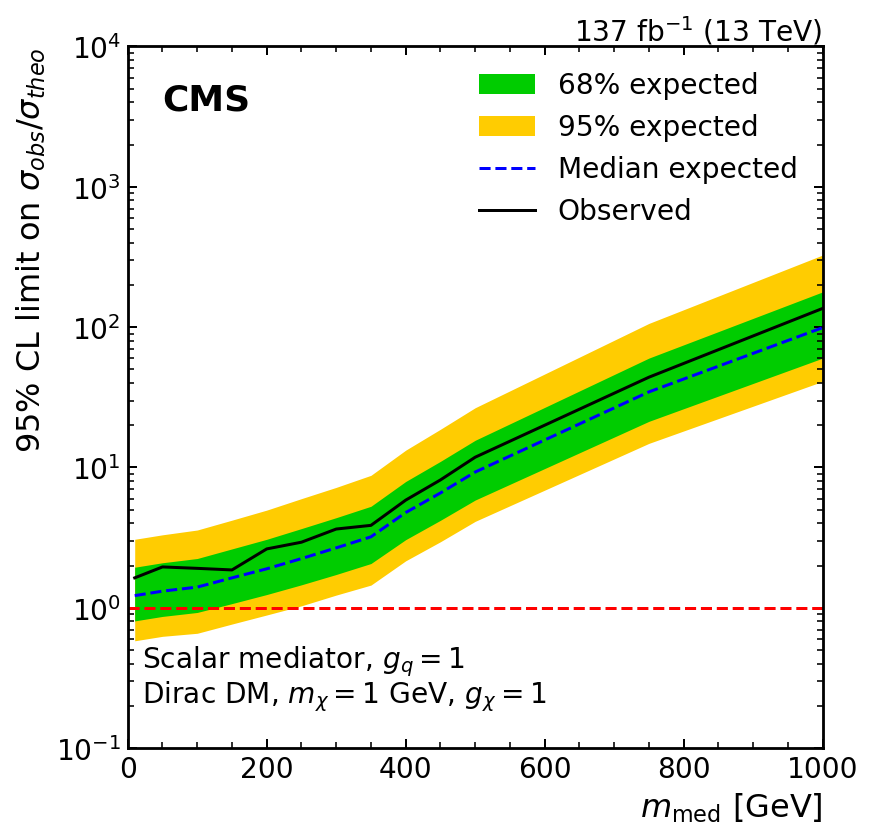

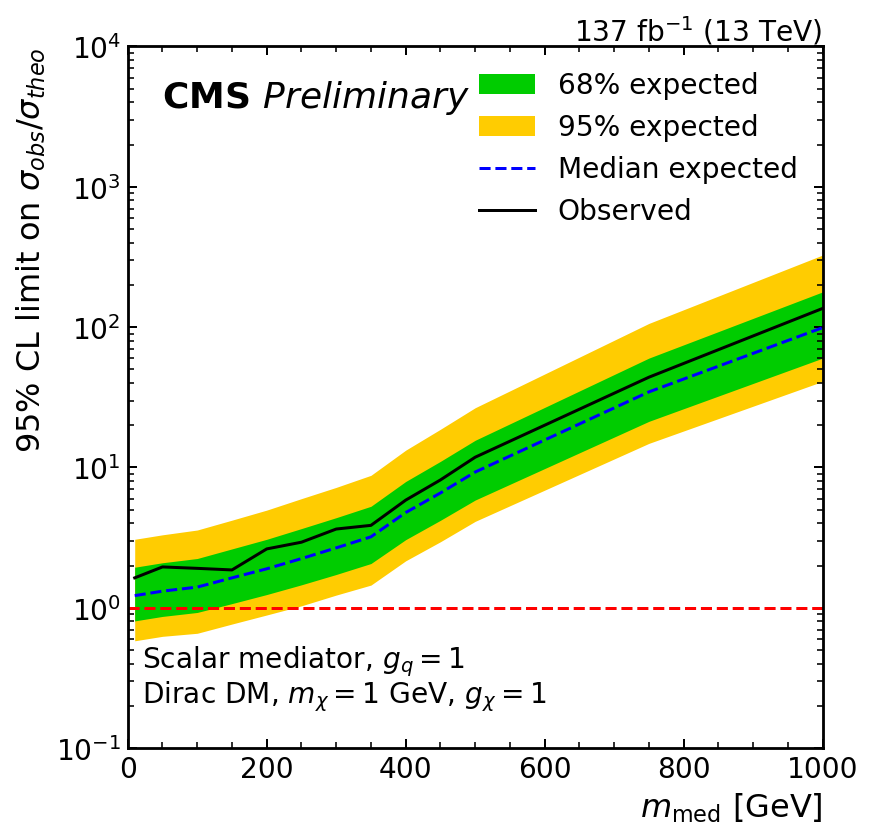

In [6]:
plot_Scalar(preliminary=False)
plot_Scalar(preliminary=True)

In [7]:
def plot_Pseudo(unblind=False, preliminary=False):
    limit_MY = []
    limit_mx = []
    limit_lm = []
    xsec = []
    mZ = 91.1876
    
    for fn, mp in mass_points("Pseudo").items():
        limit = get_limits(fn)
        if limit.shape == (2, 6):
            xsec.append(get_cross_section(fn))
            limit = np.array(limit)
            limit_lm.append(limit)
            limit_MY.append(mp[0])
            limit_mx.append(mp[1])
        else:
            pass
            #print("-> ", fn)
    xsec = np.array(xsec)
    #print("shape : ", np.array(limit_lm).astype(float) )
    #print(np.stack(limit_lm))
    data = pd.DataFrame(
        {
            "obs" : 0.02*np.array(limit_lm)[:,1,5]/xsec,
            "exp" : 0.02*np.array(limit_lm)[:,1,2]/xsec,
            "m1s" : 0.02*np.array(limit_lm)[:,1,1]/xsec,
            "p1s" : 0.02*np.array(limit_lm)[:,1,3]/xsec,
            "m2s" : 0.02*np.array(limit_lm)[:,1,0]/xsec,
            "p2s" : 0.02*np.array(limit_lm)[:,1,4]/xsec,
            "MY"  : np.array(limit_MY)
        }
    )
    data = data.sort_values(by=['MY'])
    plt.figure(figsize=(6.2,6))
    ax = plt.gca()
    plt.fill_between(data.MY, data.m1s, data.p1s,
                     color="#00CC00", lw=0, label="68% expected")
    plt.fill_between(data.MY, data.m2s, data.p2s,
                     color="#FFCC01", lw=0, label="95% expected")
    plt.fill_between(data.MY, data.m1s, data.p1s,
                     color="#00CC00", lw=0)
    plt.plot(data.MY, data.exp, marker='.', ls="--", ms=0, color="blue",  label="Median expected")
    plt.plot(data.MY, data.obs, marker='.', ls="-", ms=0, color='black', label="Observed")
    
#     cms = plt.text(
#         0., 1., r"CMS $\it{Preliminary}$" if preliminary else r"CMS" ,
#         fontsize=14, fontweight='bold',
#         horizontalalignment='left', 
#         verticalalignment='bottom', 
#         transform=ax.transAxes
#     )
    cms = plt.text(
        0.05, 0.9, u"CMS $\it{Preliminary}$" if preliminary else u"CMS",
        fontsize=18, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%1.0f fb$^{-1}$ (13 TeV)" %  137,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.text(
        0.02, 0.1, r"Pseudoscalar mediator, $g_q = 1$",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.text(
        0.02, 0.05, r"Dirac DM, ${\rm m}_{\chi} = 1$ GeV, $g_{\chi} = 1$",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.ylabel(r"$95\%$ CL limit on $\sigma_{obs}/\sigma_{theo}$", y=1, ha='right')
    plt.xlabel(r"$m_{\rm med}$ [GeV]", x=1, ha='right')
    plt.axhline(1, ls="--", color="red")
    plt.ylim([0.1, 1e4])
    plt.yscale("log")
    plt.xlim([0,1000])
    plt.legend(loc="upper right", fontsize=14)
    #plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("limit-DM-pseudo-scalar-model{}-big-CMS.pdf".format("-preliminary" if preliminary else ""), bbox_inches='tight')
    plt.savefig("limit-DM-pseudo-scalar-model{}-big-CMS.png".format("-preliminary" if preliminary else ""), bbox_inches='tight')
#     return data.MY, data.exp

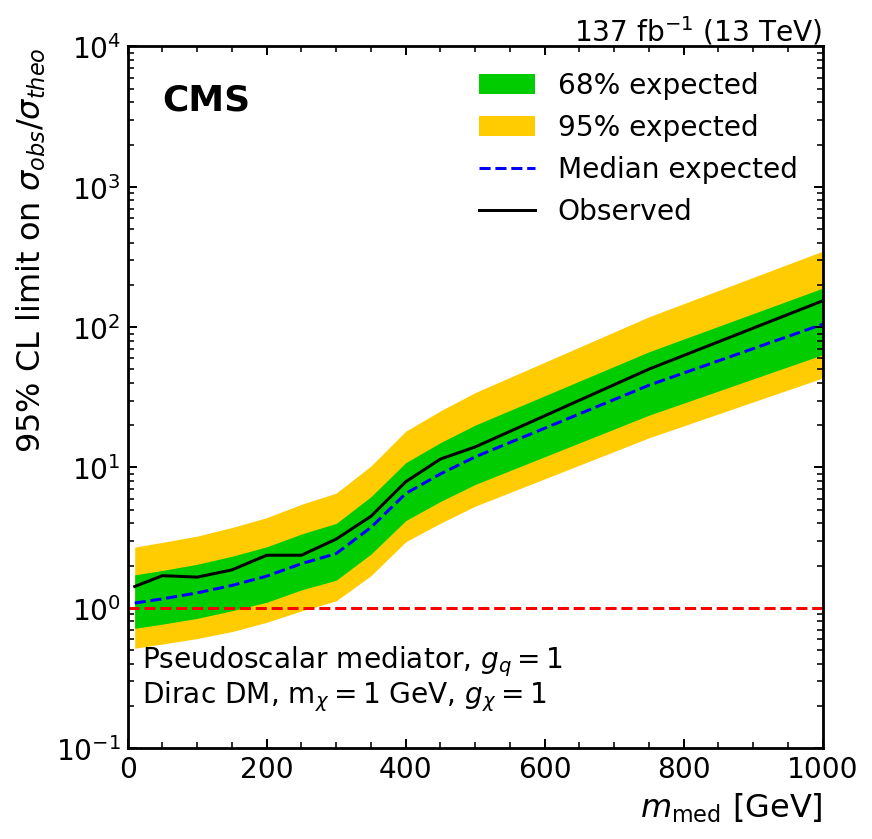

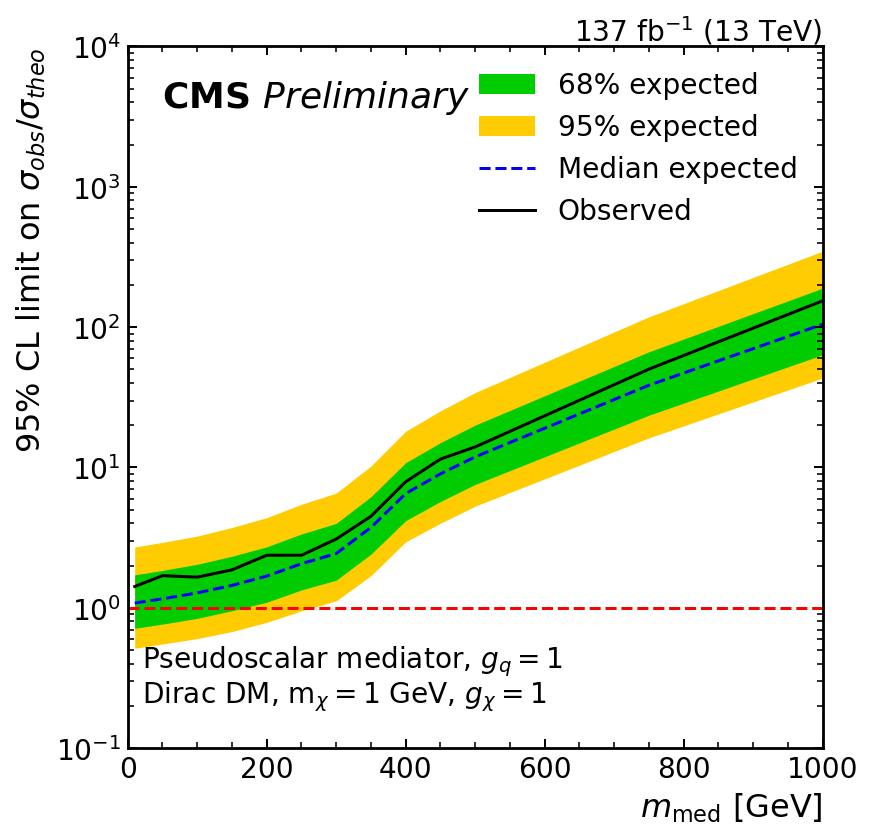

In [8]:
plot_Pseudo(preliminary=False)
plot_Pseudo(preliminary=True)